In [2]:
!nvidia-smi

Sat Feb 26 12:54:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [4]:
ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteWZ0AJY/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteWZ0AJY/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


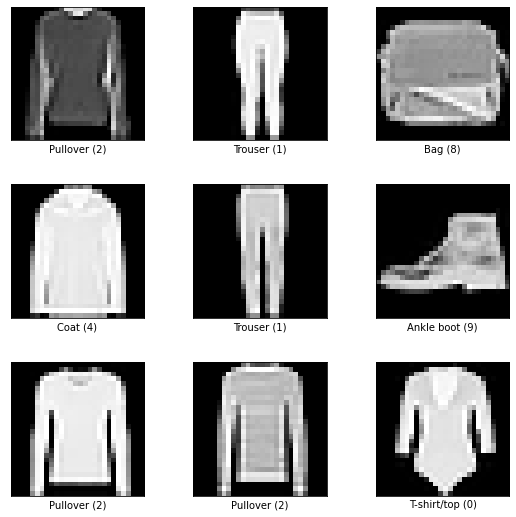

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

In [6]:
batch_size = 128
image_shape = (32,32,1)

In [7]:
def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

In [8]:
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size, drop_remainder=True).repeat()

In [9]:
train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

469


In [10]:
class WGAN_GP():
    
    def __init__(self, input_shape):
        
        self.z_dim = 128
        self.input_shape = input_shape
        
        #critic
        self.n_critic = 5
        self.penalty_const = 10
        self.critic = self.build_critic()
        self.critic.trainalbe = False
        
        self.optimizer_critic = Adam(1e-4, 0.5, 0.9)
        
        #build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer = Adam(1e-4, 0.5, 0.9))
        
    def wasserstein_loss(self, y_true, y_pred):
        
        w_loss = -tf.reduce_mean(y_true*y_pred)
        
        return w_loss
    
    def build_generator(self):
        
        DIM = 128
        
        model = tf.keras.Sequential(name='Generator')
        
        model.add(layers.Input(shape = [self.z_dim]))
        
        model.add(layers.Dense(4*4*4*DIM))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Reshape((4,4,4*DIM)))
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(2*DIM, 5, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(DIM, 5, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh'))
        
        return model
    
    def build_critic(self):
        
        DIM = 128
        
        model = tf.keras.Sequential(name='Critic')
        model.add(layers.Input(shape = self.input_shape))
        
        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1))
        
        return model
    
    def gradient_loss(self, grad):
        
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1, len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss-1))
        loss = self.penalty_const * loss
        return loss
    
    def train_critic(self, real_images, batch_size):
        
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input)
        
        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)
            
            # gradient penalty
            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon * real_images + (1-epsilon) * fake_images
            gradient_tape.watch(interpolates)
            
            critic_interpolates = self.critic(interpolates)
            gradient_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradient_interpolates)
            
            # total loss
            total_loss = loss_fake + loss_real + gradient_penalty
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.variables))
            
        return loss_fake, loss_real, gradient_penalty
    
    def train(self, data_generator, batch_size, steps, interval=100):
        
        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)
        
        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real +gradient_penalty
            
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} critic_loss {:.4f} critic_fake {:.4f} critic_real {:.4f} penalty {:.4f}"\
                .format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                print(msg)
                
                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)
                
    def plot_images(self, images):
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2.5, grid_row*2.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1]==1:
                    axarr[col].imshow(images[col, :,:,0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col, :,:,0]*0.5+0.5)
                axarr[col].axis('off')
        plt.show()

In [11]:
wgan = WGAN_GP(image_shape)

Step 0: g_loss -0.0963 critic_loss -0.0900 critic_fake 0.0085 critic_real -0.1952 penalty 0.0966


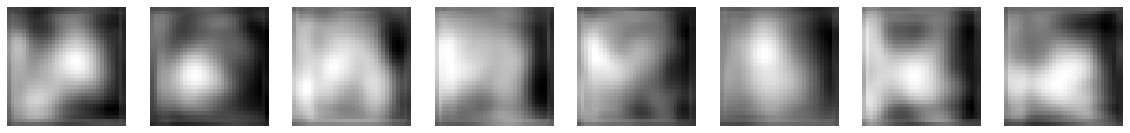

Step 100: g_loss -4.8852 critic_loss -2.1161 critic_fake -1.1218 critic_real -1.1521 penalty 0.1578


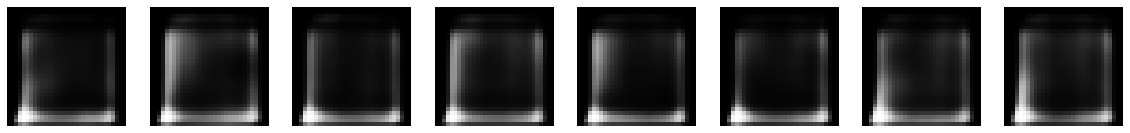

Step 200: g_loss 0.4805 critic_loss -2.4504 critic_fake -1.5932 critic_real -1.0013 penalty 0.1441


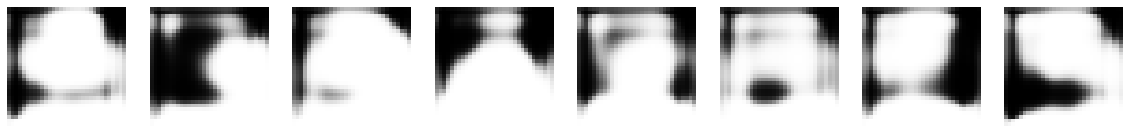

Step 300: g_loss 0.4457 critic_loss -0.6990 critic_fake -0.6342 critic_real -0.1042 penalty 0.0394


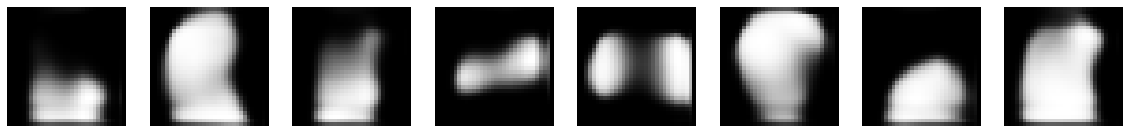

Step 400: g_loss -0.2144 critic_loss -0.5477 critic_fake 0.2800 critic_real -0.8354 penalty 0.0077


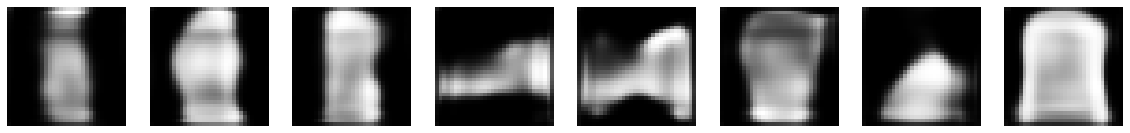

Step 500: g_loss -0.1034 critic_loss -0.5264 critic_fake 0.0659 critic_real -0.6340 penalty 0.0418


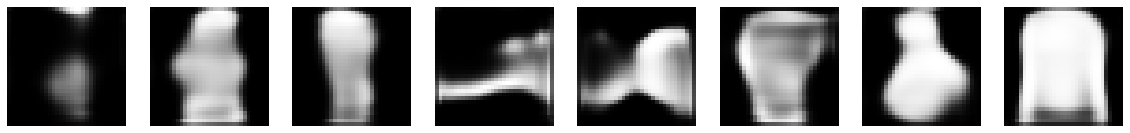

Step 600: g_loss 0.0424 critic_loss -0.5203 critic_fake -0.0016 critic_real -0.5552 penalty 0.0365


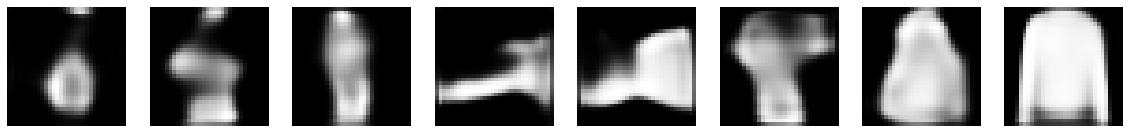

Step 700: g_loss -0.0703 critic_loss -0.5007 critic_fake 0.0455 critic_real -0.5687 penalty 0.0224


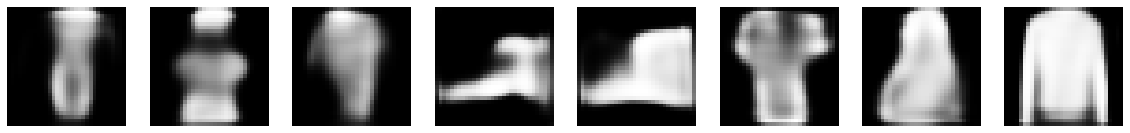

Step 800: g_loss -0.1189 critic_loss -0.4765 critic_fake 0.1134 critic_real -0.5961 penalty 0.0062


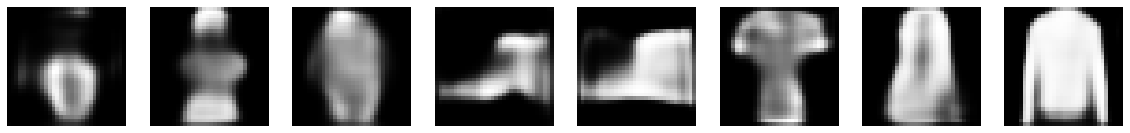

Step 900: g_loss -0.1316 critic_loss -0.4355 critic_fake 0.1601 critic_real -0.6233 penalty 0.0276


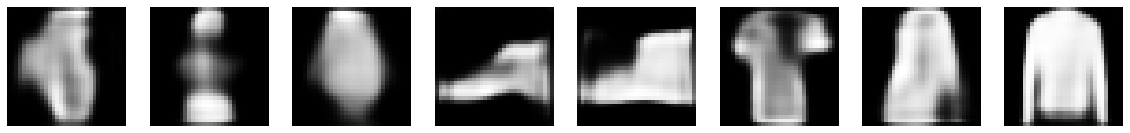

Step 1000: g_loss 0.0536 critic_loss -0.4122 critic_fake -0.0130 critic_real -0.4130 penalty 0.0137


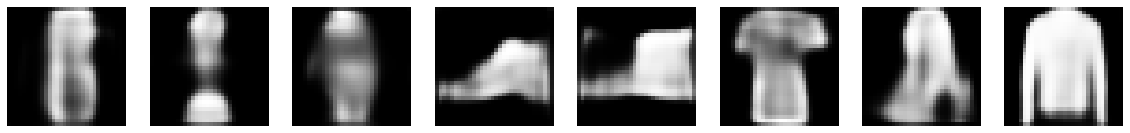

Step 1100: g_loss -0.1209 critic_loss -0.4102 critic_fake 0.1517 critic_real -0.5787 penalty 0.0168


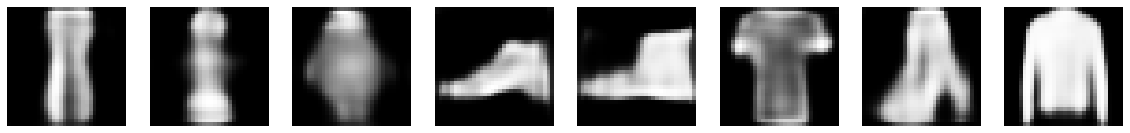

Step 1200: g_loss -0.2891 critic_loss -0.3585 critic_fake 0.3203 critic_real -0.6796 penalty 0.0008


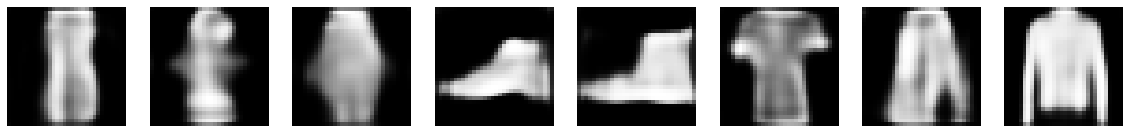

Step 1300: g_loss -0.2759 critic_loss -0.3235 critic_fake 0.3242 critic_real -0.6482 penalty 0.0005


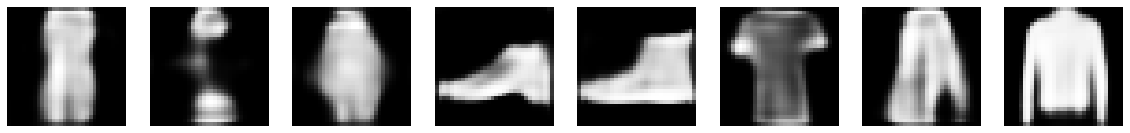

Step 1400: g_loss -0.2971 critic_loss -0.2987 critic_fake 0.2676 critic_real -0.5892 penalty 0.0229


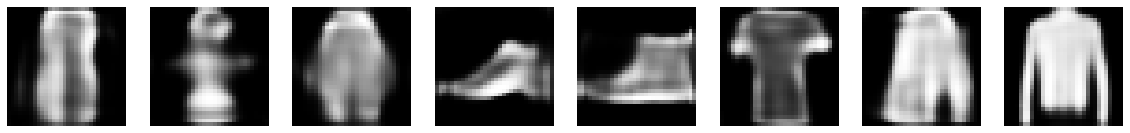

Step 1500: g_loss -0.2112 critic_loss -0.3546 critic_fake 0.2217 critic_real -0.5910 penalty 0.0147


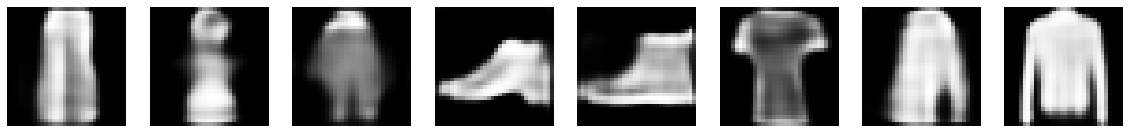

Step 1600: g_loss -0.3338 critic_loss -0.3074 critic_fake 0.3629 critic_real -0.6934 penalty 0.0231


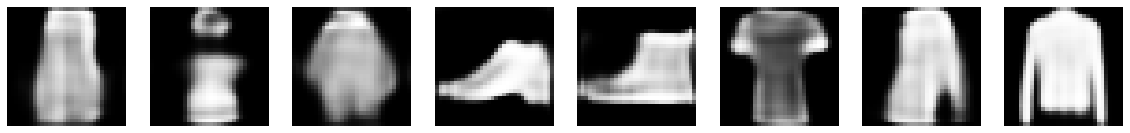

In [ ]:
wgan.train(iter(ds_train), batch_size, 5000, 100)

In [ ]:
wgan.generator.summary()

In [ ]:
wgan.critic.summary()

In [ ]:
wgan.model.summary()

In [ ]:
z = tf.random.normal((8, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)